# Programming Project #1: Hybrid Images

## CS445: Computational Photography - Spring 2020

### Part I: Hybrid Images

In [47]:

import cv2

import numpy as np
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from scipy import signal


import utils

In [48]:
%matplotlib notebook

# import matplotlib
# matplotlib.__version__

In [49]:
im1_file = './Nutmeg.jpg'
im2_file = './DerekPicture.jpg'

im1 = cv2.imread(im1_file, cv2.IMREAD_GRAYSCALE)
im2 = cv2.imread(im2_file, cv2.IMREAD_GRAYSCALE)

<IPython.core.display.Javascript object>


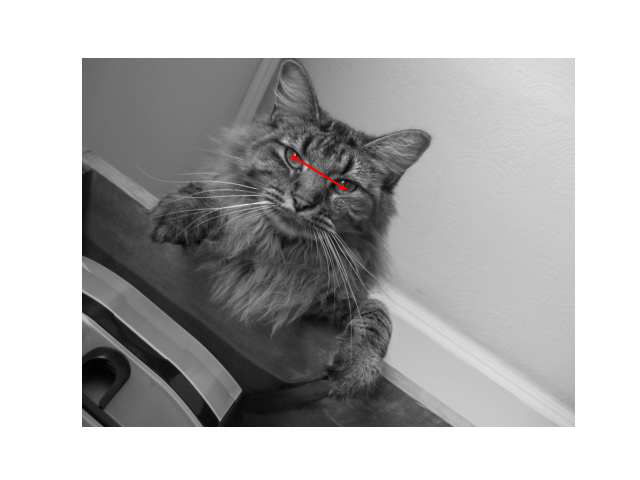

In [50]:
pts_im1 = utils.prompt_eye_selection(im1)

<IPython.core.display.Javascript object>


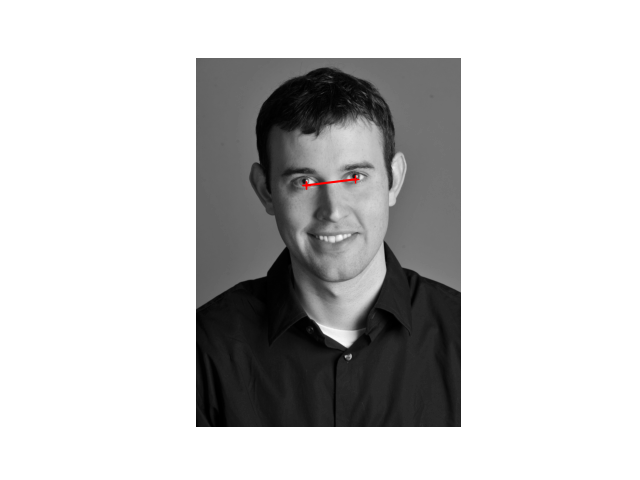

In [32]:
pts_im2 = utils.prompt_eye_selection(im2)

In [51]:
im1, im2 = utils.align_images(im1_file, im2_file,pts_im1,pts_im2,save_images=False)

In [52]:
# convert to grayscale
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY) / 255.0
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY) / 255.0

<IPython.core.display.Javascript object>


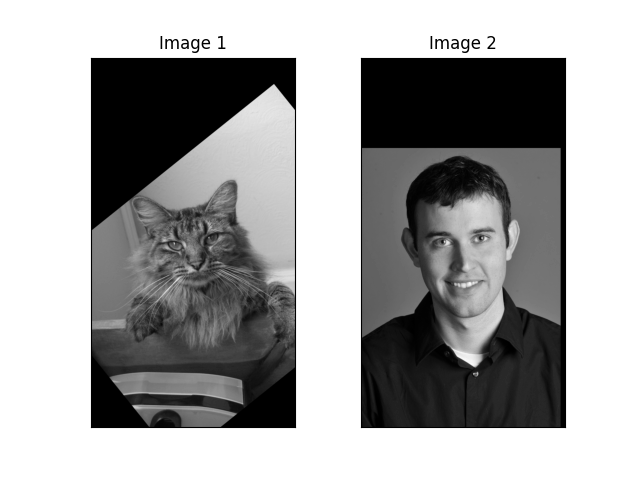

In [53]:
#Images sanity check
fig, axes = plt.subplots(1, 2)
axes[0].imshow(im1,cmap='gray')
axes[0].set_title('Image 1'), axes[0].set_xticks([]), axes[0].set_yticks([])
axes[1].imshow(im2,cmap='gray')
axes[1].set_title('Image 2'), axes[1].set_xticks([]), axes[1].set_yticks([]);

In [54]:
def filter_image(im, fil):
    '''
    im: H x W floating point numpy ndarray representing image in grayscale
    fil: M x M floating point numpy ndarray representing 2D filter
    '''
    H, W = im.shape
    hs = fil.shape[0] // 2 # half of filter size
    fftsize = max(1024 , H+hs, W+hs)        # should be order of 2 (for speed) and include padding
    im_fft = np.fft.fft2(im, (fftsize, fftsize))   # 1) fft im with padding
    fil_fft = np.fft.fft2(fil, (fftsize, fftsize)) # 2) fft fil, pad to same size as image
    im_fil_fft = im_fft * fil_fft;                 # 3) multiply fft images
    im_fil = np.fft.ifft2(im_fil_fft)              # 4) inverse fft2
    im_fil = im_fil[hs:hs + H, hs:hs + W]          # 5) remove padding
    im_fil = np.real(im_fil)                       # 6) extract out real part
    return im_fil

In [55]:
def display_frequency_image(frequency_image):
    '''
    frequency_image: H x W floating point numpy ndarray representing image after FFT
                     in grayscale
    '''
    shifted_image = np.fft.fftshift(frequency_image)
    amplitude_image = np.abs(shifted_image)
    log_amplitude_image = np.log(amplitude_image)
    fig = plt.figure()
    plt.imshow(log_amplitude_image) #cmap='gray')
    plt.colorbar()
    plt.show()

In [64]:
def hybridImage(im1, im2, cutoff_low, cutoff_high):
    '''
    Inputs:
        im1:    RGB (height x width x 3) or a grayscale (height x width) image
                as a numpy array.
        im2:    RGB (height x width x 3) or a grayscale (height x width) image
                as a numpy array.
        cutoff_low: standard deviation for the low-pass filter
        cutoff_high: standard deviation for the high-pass filter
        
    Output:
        Return the combination of both images, one filtered with a low-pass filter
        and the other with a high-pass filter.
    '''    
    # For a low-pass filter, Oliva et al. suggest using a standard 2D Gaussian filter.

    # For a high-pass filter, use the impulse filter minus the Gaussian filter, 
    # which can be computed by subtracting the Gaussian-filtered image from the original.
    '''
    high_Gaussian_filter = utils.gaussian_kernel(cutoff_high, cutoff_high*5)
    signal_filter = signal.unit_impulse(high_Gaussian_filter)
    high_filter = signal_filter - high_Gaussian_filter
    '''
    Gaussian_filter1 = utils.gaussian_kernel(cutoff_low, cutoff_low*4)
    display_frequency_image(Gaussian_filter1)
    plt.axis('off')
    plt.savefig('FFT_LOW')     

    # Gaussian_filter2 = utils.gaussian_kernel(cutoff_high, cutoff_high*4)
    # filter_impulse = signal.unit_impulse(Gaussian_filter2.shape, 'mid')
    # Gaussian_filter22 = filter_impulse - Gaussian_filter2
    # display_frequency_image(Gaussian_filter22)
    # plt.axis('off')
    # plt.savefig('./image/FFT_HIGH')

    Gaussian_filter2 = utils.gaussian_kernel(cutoff_high, cutoff_high*4)
    plt.figure()
    plt.imshow(Gaussian_filter2)
    plt.axis('off')
    plt.savefig('FFT_HIGH')

    im1_lowpass = cv2.filter2D(im1,-1,Gaussian_filter1) #filter_image(im1,Gaussian_filter1)
    im2_highpass = im2 - cv2.filter2D(im2,-1,Gaussian_filter2) #filter_image(im2,Gaussian_filter2)
    
    plt.figure()
    plt.imshow(im1_lowpass, cmap='gray')
    plt.axis('off')
    plt.savefig('dog_filter_low.jpg')
    
    plt.figure()
    plt.imshow(im2_highpass, cmap='gray')
    plt.axis('off')
    plt.savefig('me_filter_high.jpg')
    result = (im1_lowpass + im2_highpass) / 2
    return result

<IPython.core.display.Javascript object>


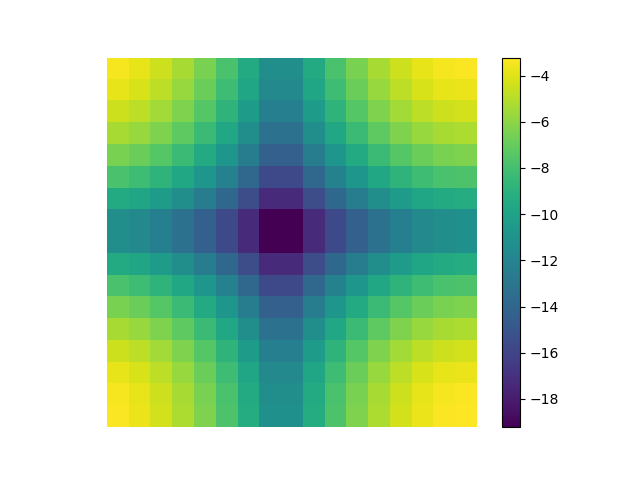

<IPython.core.display.Javascript object>


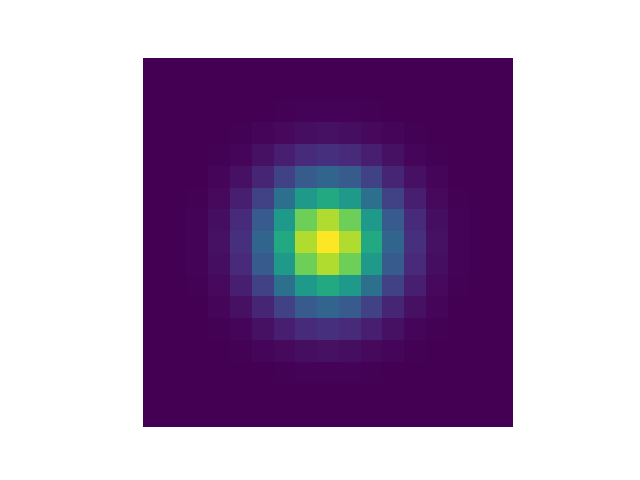

<IPython.core.display.Javascript object>


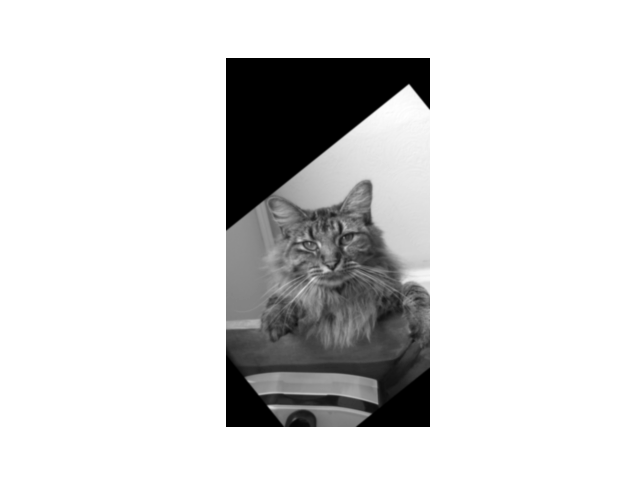

<IPython.core.display.Javascript object>


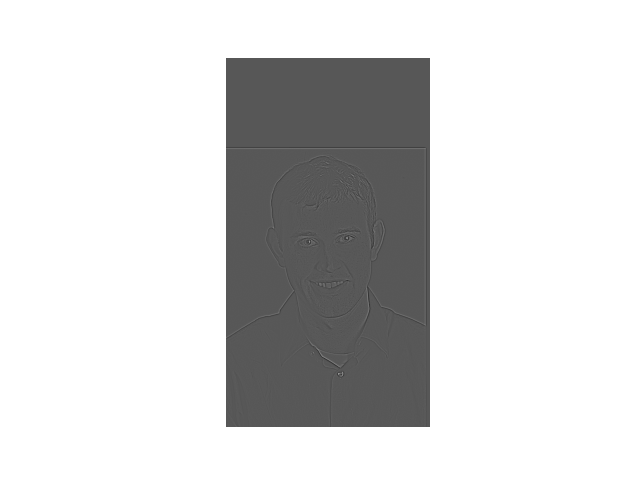

In [65]:
arbitrary_value = 20  # you should choose meaningful values; you might want to set to a fraction of image size
cutoff_low = 2   # the larger number is, the less high frequency, low frequency is more obvious
cutoff_high = 2   # the smaller number is, the less low frequency, high frequency is more obvious

im_hybrid = hybridImage(im1, im2, cutoff_low, cutoff_high)


<IPython.core.display.Javascript object>


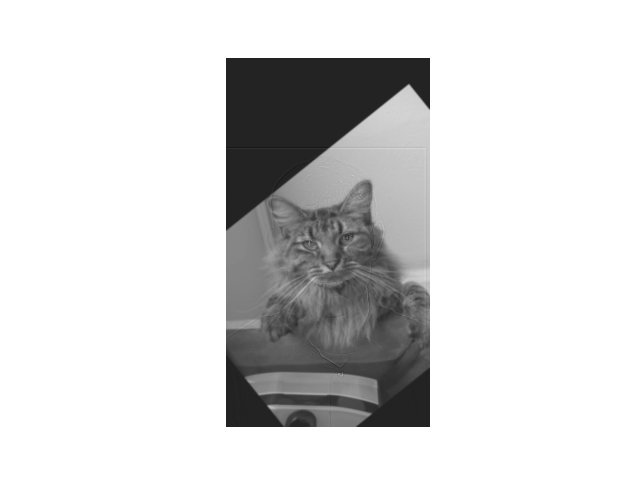

In [66]:
plt.figure()
plt.imshow(im_hybrid, cmap="gray")
plt.axis('off')
plt.savefig('hybrid.jpg')

<IPython.core.display.Javascript object>


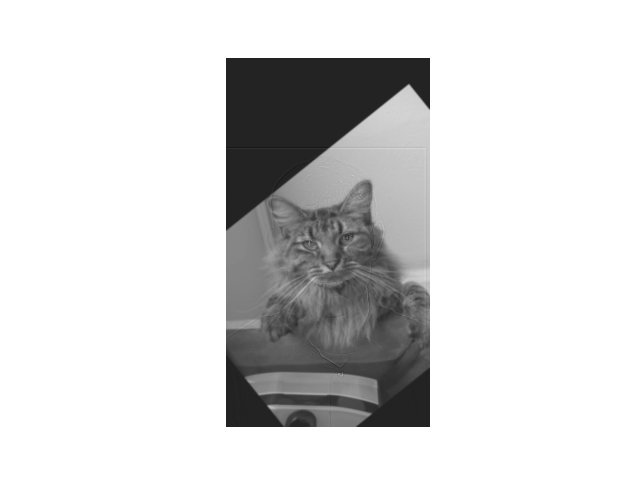

In [67]:
# Optional: Select top left corner and bottom right corner to crop image
# the function returns dictionary of 
# {
#   'cropped_image': np.ndarray of shape H x W
#   'crop_bound': np.ndarray of shape 2x2
# }
cropped_object = utils.interactive_crop(im_hybrid)

### Part II: Image Enhancement

##### Two out of three types of image enhancement are required.  Choose a good image to showcase each type and implement a method.  This code doesn't rely on the hybrid image part.

#### Contrast enhancement

#### Color enhancement 

#### Color shift